# Data Loading Pipelines

Goal: Implement efficient pipeline to load in .jpeg video frames as arrays

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd

# DALI

Resources:

- https://docs.nvidia.com/deeplearning/dali/user-guide/docs/examples/sequence_processing/sequence_reader_simple_example.html

In [1]:
import os.path
import numpy as np
import shutil

from nvidia.dali import pipeline_def
import nvidia.dali.fn as fn
import nvidia.dali.types as types

%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

In [11]:
data_dir = "/mount/data/dali_frames" #video frame directory


num_batches      = 364  #how many batches of output to produce
                       #when batch_size = 364, num_batches=1 since all our videos will be in a single batch
batch_size = 2    #364 #all 364 of our videos in a single batch
sequence_length  = 461  #each video has 461 frames

In [12]:
@pipeline_def
def frame_seq_pipe(path):
    video = fn.readers.sequence(file_root=path, sequence_length=sequence_length)
    return video

def show_sequence(sequence, sequence_length):
    columns = 5
    rows = (sequence_length + 1) // (columns)
    fig = plt.figure(figsize = (32, (16 // columns) * rows))
    gs = gridspec.GridSpec(rows, columns)
    for j in range(rows*columns):
        plt.subplot(gs[j])
        plt.axis("off")
        plt.imshow(sequence[j])

In [13]:
pipe = frame_seq_pipe(path=data_dir, batch_size=batch_size, num_threads=1, device_id=0)
pipe.build()

In [28]:
import time

all_videos = []

start = time.time()
# for i in range(1): #num_batches
    
pipe_out = pipe.run()
print(pipe_out[0].as_array().shape)
print(pipe_out[0].as_array())

#     sequences_out = np.array(pipe_out[0][0])
#     all_videos.append(sequences_out)
    
#     print(f"Batch {i} shape: {sequences_out.shape}")
    #show_sequence(sequences_out, sequence_length=5)

stop = time.time()
# np.array(all_videos).shape

(2, 461, 224, 224, 3)
[[[[[  0   0   0]
    [  0   0   0]
    [  0   0   0]
    ...
    [184 207 221]
    [184 207 221]
    [184 207 221]]

   [[  0   0   0]
    [  0   0   0]
    [  0   0   0]
    ...
    [184 207 221]
    [184 207 221]
    [184 207 221]]

   [[  0   0   0]
    [  0   0   0]
    [  0   0   0]
    ...
    [184 207 221]
    [184 207 221]
    [184 207 221]]

   ...

   [[  0   0   0]
    [  0   0   0]
    [  0   0   0]
    ...
    [128 145 152]
    [128 145 152]
    [128 145 152]]

   [[  0   0   0]
    [  0   0   0]
    [  0   0   0]
    ...
    [128 145 152]
    [128 145 152]
    [128 145 152]]

   [[  0   0   0]
    [  0   0   0]
    [  0   0   0]
    ...
    [128 145 152]
    [128 145 152]
    [128 145 152]]]


  [[[  0   0   0]
    [  0   0   0]
    [  0   0   0]
    ...
    [184 207 221]
    [184 207 221]
    [184 207 221]]

   [[  0   0   0]
    [  0   0   0]
    [  0   0   0]
    ...
    [184 207 221]
    [184 207 221]
    [184 207 221]]

   [[  0   0   0]
    [ 

In [19]:
videos = np.array(all_videos)
videos[0].shape

(461, 224, 224, 3)

### Checking to see if N_ITER wraps around when N_ITER > num. of videos in directory

In [48]:
for i in range(len(videos)):
    curr_frame = videos[i][350]
    for j in range(len(videos)):
        if (curr_frame == videos[j][350]).all() and (i != j):
            print(f'{i} and {j} have the same frame at index 350.')
            
## we have duplicate videos loaded in at index 240, 364, and 365
## 240 might be a pre-existing duplicate in our dataset 
## 364 and 365 are most-likely duplicates based on the N_ITER > 364 and wrapping around
## the last original video loaded in w/o wrapping around has index 363 bc of 0-based indexing (i=363 is the 364th video)

0 and 364 have the same frame at index 350.
1 and 365 have the same frame at index 350.
227 and 240 have the same frame at index 350.
240 and 227 have the same frame at index 350.
364 and 0 have the same frame at index 350.
365 and 1 have the same frame at index 350.


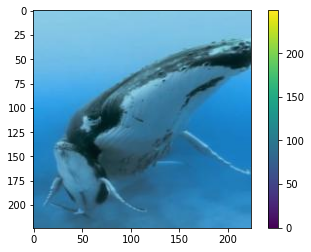

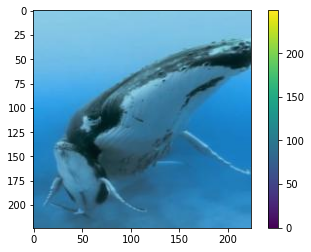

In [94]:
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(videos[227][350])
plt.colorbar()
plt.grid(False)
plt.show()

plt.figure()
plt.imshow(videos[240][350])
plt.colorbar()
plt.grid(False)
plt.show()

In [62]:
#count of videos in our dataset
import pandas as pd

df = pd.read_csv('/mount/data/downloaded_videos.csv')
df.shape

(364, 12)

In [64]:
#count of videos in our directory (includes one extra)
import os
print(len(next(os.walk('/mount/data/dali_frames'))[1]))

365


In [66]:
#remove the folder with the name that is not in our df
folders = os.listdir('/mount/data/dali_frames')
print(len(folders))

365


In [76]:
true_video_names = list(df['renamed_title'].values)
true_video_names = [name.replace('_', '_clip_').replace('.mp4', '') for name in true_video_names]
true_video_names[0:5]

['video_clip_0000',
 'video_clip_0001',
 'video_clip_0002',
 'video_clip_0003',
 'video_clip_0004']

In [80]:
for video_file in folders:
    if video_file not in true_video_names:
        print(video_file)

.ipynb_checkpoints


In [102]:
df.title.value_counts() > 1

# df[df.title == 'king whale (2021) #shorts']
# df[df.title == 'Follow for more video       #reels  #explorepage #explore #youradventuregram #nature #sea #ocean']

king whale (2021) #shorts                                                                              True
Humpback Whales                                                                                        True
whale sound (2021) #shorts# amazing sound wanle                                                        True
Humpback Whale                                                                                         True
Follow for more video       #reels  #explorepage #explore #youradventuregram #nature #sea #ocean       True
                                                                                                      ...  
Up She rises  Humpback Whale air lifts seagull                                                        False
CIMS Humpback Responds20110731                                                                        False
Kayakers Get the Surprise Of Their Life- Humpback Whale Surprise- Wait For It- Inches From kayaker    False
Humpback whale breach compil

`how does DALI pipelines work for image reading? What are the iterations for?`

`why am I able to go through 365 iterations when I only have 364 videos? Why do we need to iterate? What does pip.run() return?`

# HDF5

Resources:
- https://realpython.com/storing-images-in-python/

## Reading .JPEG Images into HDF5 Dataset + Labels

In [60]:
from hdf5_data_loading import *

sequence_length = 461
df = pd.read_csv("/mount/data/downloaded_videos.csv")

for i, row in df[0:5].iterrows():
    frame_labels = [int(row['relevant']) for i in range(sequence_length)]
    video_clip = row['renamed_title'].replace("_", "_clip_")
    fn = video_clip.replace(".mp4", "")
    
    _, frames = get_video_frames(video_clip, max_frames=sequence_length)
    store_frames_hdf5(frames, frame_labels, fn)

print('Done.')

Done.


In [61]:
frames, labels = read_frames_hdf5("video_clip_0004")

In [62]:
frames.shape

(461, 224, 224, 3)

In [64]:
labels.min()

1

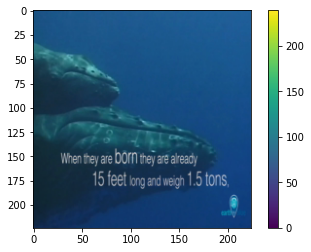

In [66]:
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(frames[350])
plt.colorbar()
plt.grid(False)
plt.show()